In [12]:
# main library
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max.colwidth', 500)


from IPython.core.display import display, HTML
display(HTML("<style>.container { width : 100% !important;}</style>"))

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


In [ ]:
train_url = "../dataset/train.csv"
questions_url = "../dataset/questions.csv"
lectures_url = "../dataset/lectures.csv"

dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id" : "int8",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32" 
}

train = pd.read_csv(train_url, dtype = dtypes)
questions = pd.read_csv(questions_url)
lectures = pd.read_csv(lectures_url)

In [101]:
# some initial parameter using optuna & basic model
params = {
    'bagging_fraction': 0.33144702969009193,
    'feature_fraction': 0.9391410014954418,
    'learning_rate': 0.22978527028142218, 
    'max_depth': 8,
    'min_child_samples': 736, 
    'min_data_in_leaf': 60, 
    'n_estimators': 236,
    'num_leaves': 24,
    'random_state': 777
}

model = LGBMClassifier(**params)

In [65]:
# Divide some features with target variable.

features = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer',
       'prior_question_elapsed_time', 'prior_question_had_explanation']
target = "answered_correctly"

In [66]:
train.isnull().sum()

row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
answered_correctly                     0
prior_question_elapsed_time       392506
prior_question_had_explanation         0
dtype: int64

In [30]:
# nan 값을 우선적으로 id 별 평균으로 메우려는 시도를 하고자 함

user_id
115           19933.310547
124           18793.000000
2746          18055.554688
5382          36048.386719
8623          26107.408203
                  ...     
2147470770    23167.382812
2147470777    20028.103516
2147481750    17938.775391
2147482216    19562.042969
2147482888    27192.308594
Name: prior_question_elapsed_time, Length: 393656, dtype: float32

In [26]:
# Should solve some nan values in prior_question_had_explanation

train.prior_question_had_explanation = train.prior_question_had_explanation.fillna(value = False).astype(bool)

train.prior_question_had_explanation.isnull().sum()

In [52]:
# target variable should include only 1 or 0 일단 lecture인 행은 모두 날려버림(문제끼리만 확인하기 위하여)
train = train[train.answered_correctly != -1]

In [56]:
train.answered_correctly = train.answered_correctly.astype("bool")

/Users/entrekid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [67]:
features

['row_id',
 'timestamp',
 'user_id',
 'content_id',
 'content_type_id',
 'task_container_id',
 'user_answer',
 'prior_question_elapsed_time',
 'prior_question_had_explanation']

In [100]:
train_df, test_df = train_test_split(train, random_state = 777, test_size = 0.2)

In [70]:
train_df[target].value_counts()

True     52198372
False    27218668
Name: answered_correctly, dtype: int64

In [102]:
model.fit(train_df[features], train_df[target])

ans = model.predict_proba(test_df[features])

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=736 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.9391410014954418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9391410014954418
[LightGBM] [Warning] bagging_fraction is set=0.33144702969009193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33144702969009193


LGBMClassifier(bagging_fraction=0.33144702969009193,
               feature_fraction=0.9391410014954418,
               learning_rate=0.22978527028142218, max_depth=8,
               min_child_samples=736, min_data_in_leaf=60, n_estimators=236,
               num_leaves=24, random_state=777)

In [110]:
questions[questions.question_id != questions.bundle_id]

,question_id,bundle_id,correct_answer,part,tags
1401,1401,1400,0,3,136 92 102
1402,1402,1400,1,3,82 92 102
1404,1404,1403,0,3,136 38 29
1405,1405,1403,3,3,82 38 29
1407,1407,1406,3,3,136 38 102
...,...,...,...,...,...
13246,13246,13244,1,3,136 81 92
13248,13248,13247,2,3,136 81 92
13249,13249,13247,1,3,136 81 92
13251,13251,13250,2,3,136 81 92


In [109]:
answer_mean = train.groupby(["content_id"])["answered_correctly"].agg("mean")

In [119]:
answer_mean.shape

(13523,)

In [120]:
questions.shape

(13523, 5)

In [104]:
print('LGB score: ', roc_auc_score(test_df[target].values, ans[:,1]))

LGB score:  0.6965434714417217


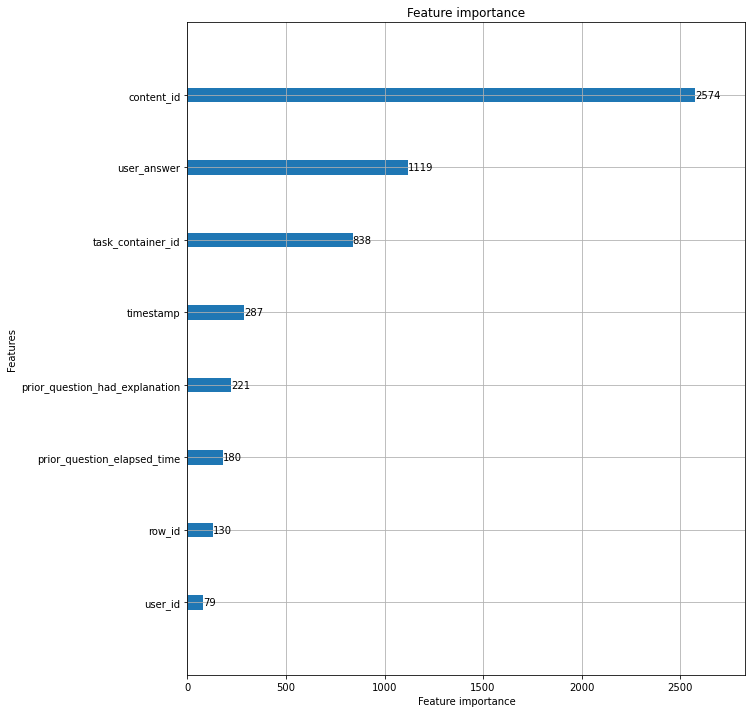

In [105]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model, ax = ax)

In [123]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [131]:
import gc
gc.collect()

1766

# train + question

In [150]:
questions = pd.read_csv(questions_url)

In [151]:
train_questions = pd.merge(train, questions, how = "left", left_on = "content_id", right_on = "question_id")

In [152]:
train_df, test_df = train_test_split(train_questions, random_state = 777, test_size = 0.2)

In [153]:
# some initial parameter using optuna & basic model
params = {
    'bagging_fraction': 0.33144702969009193,
    'feature_fraction': 0.9391410014954418,
    'learning_rate': 0.22978527028142218, 
    'max_depth': 8,
    'min_child_samples': 736, 
    'min_data_in_leaf': 60, 
    'n_estimators': 236,
    'num_leaves': 24,
    'random_state': 777
}


model2 = LGBMClassifier(**params)

In [154]:
train_df.columns

Index([                        'row_id',                      'timestamp',
                              'user_id',                     'content_id',
                      'content_type_id',              'task_container_id',
                          'user_answer',             'answered_correctly',
          'prior_question_elapsed_time', 'prior_question_had_explanation',
                                      0,                                1,
                                      2,                                3,
                          'question_id',                      'bundle_id',
                       'correct_answer',                           'part',
                                 'tags'],
      dtype='object')

In [159]:
features = [  'row_id',                      'timestamp',
                              'user_id',                     'content_id',
                      'content_type_id',              'task_container_id',
                          'user_answer',            
          'prior_question_elapsed_time', 'prior_question_had_explanation',
                                      0,                                1,
                                      2,                                3,
                          'question_id',                      'bundle_id',
                       'correct_answer',                           'part'
                                 ]
target = "answered_correctly"

In [158]:
train_df[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79417040 entries, 16484296 to 92125999
Data columns (total 18 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  bool   
 9   0                               uint8  
 10  1                               uint8  
 11  2                               uint8  
 12  3                               uint8  
 13  question_id                     int64  
 14  bundle_id                       int64  
 15  correct_answer                  int64  
 16  part                            int64  
 17  tags              

In [160]:
model2.fit(train_df[features], train_df[target])

ans = model2.predict_proba(test_df[features])

print('LGB score: ', roc_auc_score(test_df[target].values, ans[:,1]))

[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=736 will be ignored. Current value: min_data_in_leaf=60
[LightGBM] [Warning] feature_fraction is set=0.9391410014954418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9391410014954418
[LightGBM] [Warning] bagging_fraction is set=0.33144702969009193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.33144702969009193
LGB score:  1.0


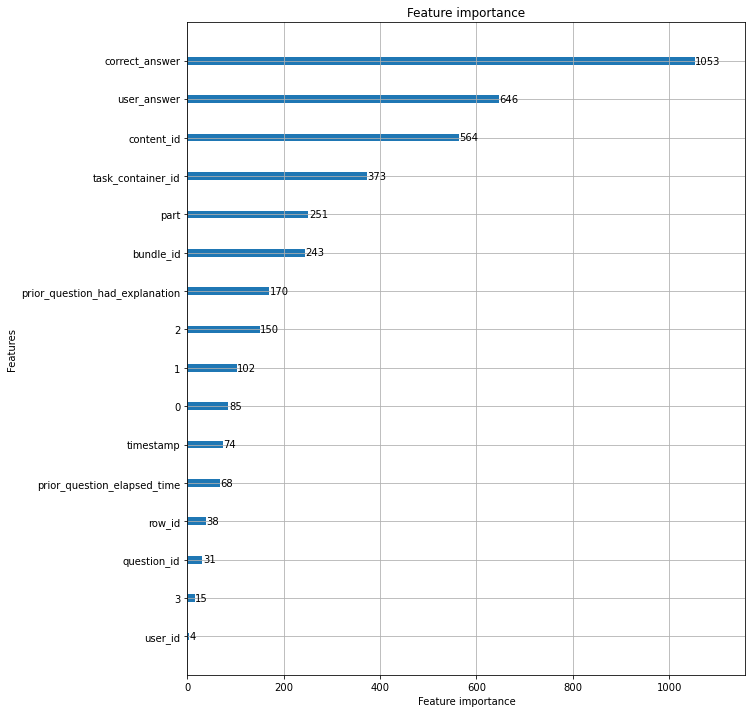

In [161]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model2, ax = ax)

# train + question(정답률 추가)

In [162]:
answer_mean = train.groupby(["content_id"])["answered_correctly"].agg("mean")

In [163]:
answer_mean = pd.DataFrame(answer_mean)

In [143]:
answer_mean.head()

,answered_correctly
content_id,
0,0.907721
1,0.890646
2,0.554281
3,0.779437
4,0.613215


In [137]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


## questions + answer_mean

In [164]:
questions = pd.merge(questions, answer_mean, how = "left", left_on = "question_id", right_on = "content_id")
train_questions = pd.merge(train, questions, how = "left", left_on = "content_id", right_on = "question_id")

In [165]:
train_df, test_df = train_test_split(train_questions, random_state = 777, test_size = 0.2)

In [166]:
# some initial parameter using optuna & basic model
params = {
    'bagging_fraction': 0.33144702969009193,
    'feature_fraction': 0.9391410014954418,
    'learning_rate': 0.22978527028142218, 
    'max_depth': 8,
    'min_child_samples': 736, 
    'min_data_in_leaf': 60, 
    'n_estimators': 236,
    'num_leaves': 24,
    'random_state': 777
}

model = LGBMClassifier(**params)


In [ ]:
features = [  'row_id',                      'timestamp',
                              'user_id',                     'content_id',
                      'content_type_id',              'task_container_id',
                          'user_answer',            
          'prior_question_elapsed_time', 'prior_question_had_explanation',
                                      0,                                1,
                                      2,                                3,
                          'question_id',                      'bundle_id',
                       'correct_answer',                           'part',
            ""
                                 ]
target = "answered_correctly"

In [149]:
model.fit(train_df[features], train_df[target])

ans = model.predict_proba(test_df[features])

print('LGB score: ', roc_auc_score(test_df[target].values, ans[:,1]))

KeyError: 'answered_correctly'

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(model, ax = ax)